In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(1234)

In [ ]:
print(tf. __version__)

2.7.0


In [18]:

#The Data Path
images=np.load("/content/drive/MyDrive/stanford_merchantdata256x256.npz")
x=images.f.x
y=images.f.y
x=np.reshape(x,(290,256,256,1))

In [19]:
np.min(x)

-0.10883099

In [20]:
for j in range(len(x)):
  x[j,:,:,0]=(x[j,:,:,0]/np.max(x[j,:,:,0]))

In [21]:
from skimage.filters import gaussian


#For to increase the areas of the heat points 

for k in range(len(y)):
  for l in range(6):
    if 0>np.min(y[k,:,:,l]):
        y[k,:,:,l]=y[k,:,:,l]-np.min(y[k,:,:,l]) 
    y[k,:,:,l]=gaussian(y[k,:,:,l],sigma=4)
    y[k,:,:,l]=y[k,:,:,l]*(1/np.max(y[k,:,:,l]))


x_train=x[:,:,:,:]
#x_test=x[280:,:,:,:]

y_train=y[:,:,:,:]
#y_test=y[280:,:,:,:]

In [22]:
def points_max_value(predict):
    points=np.zeros([6,2])
    for i in range(6):
        pre=predict[0,:,:,i]
        points[i,:]=np.where(pre == pre.max())
    return np.fliplr(np.int32(points))

def put_text_point(original_img,heatpoint):
    color = (0, 51, 204)
    img = cv2.cvtColor(original_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
    for i in range(6):
      if heatpoint[i,0]<=0 and heatpoint[i,1]<=0:
          print("L"+np.str(i)+" There is no Point")
      else :
          if i>2:
              coordx=0
              coordy=-(i*3)
          else:
              coordx=-(i*3)
              coordy=+(i*3)+10
          img=cv2.putText(img, "L"+np.str(i),(heatpoint[i,0]+coordx,heatpoint[i,1]+coordy), cv2.FONT_HERSHEY_SIMPLEX,0.35, 	color, 1)   
          img = cv2.circle(img, (heatpoint[i,0],heatpoint[i,1]), radius=2, color=color, thickness=-1)
    return img


In [23]:
import cv2
ff=71
img=x[ff,:,:]
img=np.reshape(img,(1,256,256,1))
maxx=y[ff,:,:,:]
maxx=np.reshape(maxx,(1,256,256,6))
heatpoint=points_max_value(maxx)
v=put_text_point(np.uint(img[0,:,:,0]*255),heatpoint)


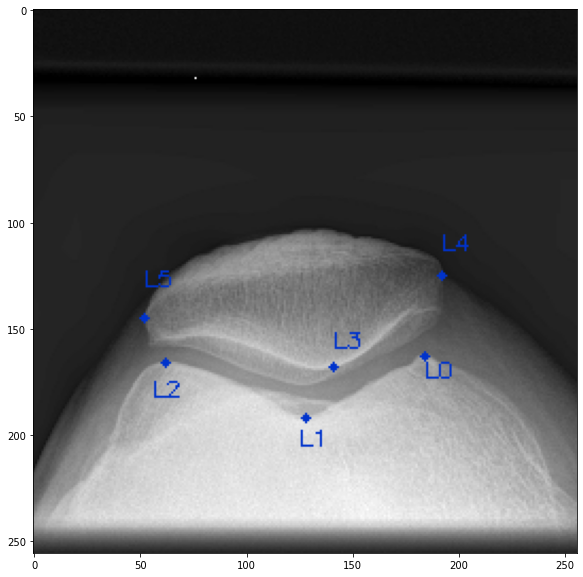

In [24]:
plt.figure(figsize = (20,10))
plt.imshow(v)

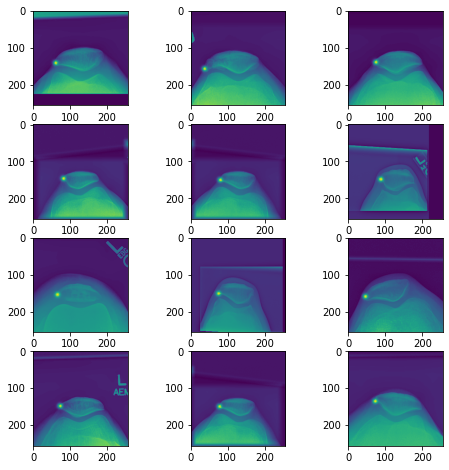

In [ ]:
from random import randint

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for i in range(1, columns*rows +1):
    value1 = randint(0, len(x_train))
    img = x_train[value1,:,:,0]+y_train[value1,:,:,5]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-wm8oyc_5
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-wm8oyc_5
     |████████████████████████████████| 47.7 MB 68.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112538 sha256=0cebe523f22deb417a13b0af199e17eb3422977ea2ed85273686de564d693943
  Stored in directory: /tmp/pip-ephem-wheel-cache-4jrdakv3/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A
import cv2
#28-12-2021 ShiftScale 0.0625 to 0.325 . L1 always was on the same point.
aug = A.Compose([
    A.OneOf([A.RandomCrop(width=256, height=256),
                 A.PadIfNeeded(min_height=256, min_width=256, p=0.5)],p=0.4),
    A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25,p=0.5),
    A.Compose([A.RandomScale(scale_limit=(-0.15, 0.15), p=1, interpolation=1),
                            A.PadIfNeeded(256, 256, border_mode=cv2.BORDER_CONSTANT), 
                            A.Resize(256, 256, cv2.INTER_NEAREST), ],p=0.5),
    A.ShiftScaleRotate (shift_limit=0.325, scale_limit=0.15, rotate_limit=15,border_mode=cv2.BORDER_CONSTANT, p=1),
    A.Rotate(15,p=0.5),
    A.Blur(blur_limit=1, p=0.5),
    A.Downscale(scale_min=0.15, scale_max=0.25,  always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(0.05, 0.1), mean=0, per_channel=True, always_apply=False, p=0.5),
])

x_train1=np.copy(x_train)
y_train1=np.copy(y_train)
count=0
while(count<10):
  x_aug2=np.copy(x_train1)
  y_aug2=np.copy(y_train1)
  for i in range(len(x_train1)):
    augmented=aug(image=x_train1[i,:,:,:],mask=y_train1[i,:,:,:])
    x_aug2[i,:,:,:]= augmented['image']
    y_aug2[i,:,:,:]= augmented['mask']
  x_train=np.concatenate((x_train,x_aug2))
  y_train=np.concatenate((y_train,y_aug2))
  if count == 9:
    break
  count += 1

In [ ]:
#For Relase unneccasery memory
del x_aug2
del x
del y
del y_aug2
del y_train1
del x_train1
del augmented

In [ ]:
x_train.shape

(3190, 256, 256, 1)

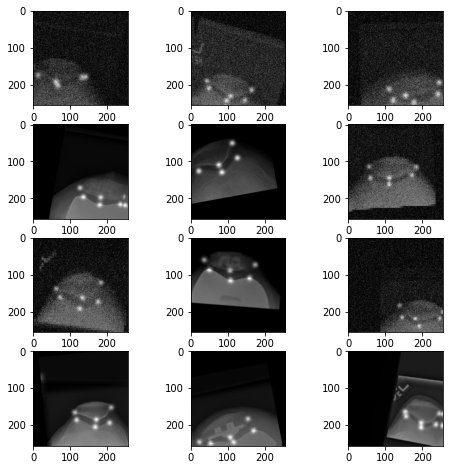

In [ ]:
from random import randint

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 4
for r in range(1, columns*rows +1):
  value = randint(0, len(x_train))
  img = x_train[value,:,:,0]+y_train[value,:,:,0]+ y_train[value,:,:,1]+ y_train[value,:,:,2]+ y_train[value,:,:,3]+ y_train[value,:,:,4]+ y_train[value,:,:,5]
  fig.add_subplot(rows, columns, r)
  plt.imshow(img,cmap="gray")
plt.show()

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization,concatenate,Conv2DTranspose,Dropout,AveragePooling2D,Add


def Spatial_Configuration1(convc) :
  sconv = AveragePooling2D(pool_size=(16, 16))(convc)

  sconv = Conv2D(128,(11,11),padding="same",  kernel_initializer = 'he_normal')(sconv)
  sconv=BatchNormalization()(sconv)
  sconv=tf.keras.layers.LeakyReLU( alpha=0.1)(sconv)
  sconv=Dropout(0.5)(sconv)

  sconv = Conv2D(128,(11,11), padding="same" , kernel_initializer = 'he_normal')(sconv)
  sconv_c=BatchNormalization()(sconv)
  sconv=tf.keras.layers.LeakyReLU( alpha=0.1)(sconv)
  sconv=Dropout(0.5)(sconv)

  sconv = Conv2D(128,(11,11),padding="same", kernel_initializer = 'he_normal')(sconv)
  sconv=BatchNormalization()(sconv)
  sconv=tf.keras.layers.LeakyReLU(alpha=0.1)(sconv)
  sconv=Dropout(0.5)(sconv)

  sconv = Conv2D(6,(11,11), activation = "tanh", padding="same", kernel_initializer =tf.keras.initializers.RandomNormal(stddev=0.0001),kernel_regularizer=tf.keras.regularizers.l2(0.0005))(sconv)
  sconv1 = tf.keras.layers.UpSampling2D(size=(16, 16),interpolation='bilinear')(sconv)
  return sconv1


def UNet(inputs,x_dim,y_dim):
  
  u = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  u=BatchNormalization()(u)
  u = Conv2D(32,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  
  u=Dropout(0.1)(u)
  u1 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  

  u = AveragePooling2D(pool_size=(2, 2))(u1)
  u = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  
  u=Dropout(0.2)(u)
  u2 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)

  u = AveragePooling2D(pool_size=(2, 2))(u2)
  u = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  
  u=Dropout(0.3)(u)
  u3 = Conv2D(128,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  

  u = AveragePooling2D(pool_size=(2, 2))(u3)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  
  u=Dropout(0.3)(u)
  u4 = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  

  u = AveragePooling2D(pool_size=(2, 2))(u4)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u) 
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u) 
  u=BatchNormalization()(u)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(256,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u) 
  u=BatchNormalization()(u)
  u = Conv2D(512,(3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)  
  u=BatchNormalization()(u)


  u = tf.keras.layers.UpSampling2D(interpolation='bilinear')(u)
  u = Conv2D(256,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(256,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=Add()([u,u4])

  u = tf.keras.layers.UpSampling2D(interpolation='bilinear')(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=Add()([u,u3])

  u = tf.keras.layers.UpSampling2D(interpolation='bilinear')(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=Add()([u,u2])

  u = tf.keras.layers.UpSampling2D(interpolation='bilinear')(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(128,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=Add()([u,u1])

  u = Conv2D(64,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)
  u=BatchNormalization()(u)
  u=Dropout(0.3)(u)
  u = Conv2D(32,3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(u)

  return u


In [ ]:

class Adaptive_Wing_Loss():
    def __init__(self, alpha=float(2.1), omega=float(5), epsilon=float(1),theta=float(0.5)):   
        self.alpha=alpha
        self.omega=omega
        self.epsilon=epsilon
        self.theta=theta
    def Loss(self,y_true,y_pred):
        A = self.omega * (1/(1+(self.theta/self.epsilon)**(self.alpha-y_true)))*(self.alpha-y_true)*((self.theta/self.epsilon)**(self.alpha-y_true-1))/self.epsilon
        C = self.theta*A - self.omega*tf.math.log(1+(self.theta/self.epsilon)**(self.alpha-y_true))
        loss=tf.where(tf.math.greater_equal(tf.math.abs(y_true-y_pred), self.theta),A*tf.math.abs(y_true-y_pred) - C,self.omega*tf.math.log(1+tf.math.abs((y_true-y_pred)/self.epsilon)**(self.alpha-y_true)))
        return tf.reduce_mean(loss)+tf.compat.v1.losses.get_regularization_loss()

AWL=Adaptive_Wing_Loss()
inputs=tf.keras.layers.Input(shape=(256,256,1))

unet_output=UNet(inputs,256,256)
local_app = Conv2D(6,(1,1), activation = "linear", padding = 'same', kernel_initializer = tf.keras.initializers.RandomNormal(stddev=0.0001),kernel_regularizer=tf.keras.regularizers.l2(0.0005))(unet_output)

config_output=Spatial_Configuration1(local_app)
outputs = tf.keras.layers.Multiply()([local_app,config_output])


#28-12-2021 Learning Rate  1e-5  to 1e-6 

model = tf.keras.Model(inputs = inputs, outputs = [local_app,outputs])
model.compile(loss=AWL.Loss,optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),metrics="MSE")

In [ ]:
model.summary()

In [ ]:
model.fit(x=x_train,y=[y_train,y_train],epochs=500,batch_size=8)

In [ ]:
#YourPath
model.save('/content/drive/MyDrive/SavedModel500Epochs')

In [ ]:
import tensorflow as tf
#If you convert to tflite 

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/SavedModel500Epochs") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)